In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, accuracy_score
from sklearn.metrics import hamming_loss

In [6]:
file = open('/content/drive/MyDrive/Other Files/WISDM_ar_v1.1_raw.txt')
lines = file.readlines()

processedList = []

for i, line in enumerate(lines):
    try:
        line = line.split(',')
        last = line[5].split(';')[0]
        last = last.strip()
        if last == '':
            break;
        temp = [line[0], line[1], line[2], line[3], line[4], last]
        processedList.append(temp)
    except:
        print('Error at line number: ', i)

Error at line number:  281873
Error at line number:  281874
Error at line number:  281875


In [7]:
processedList[:100]

[['33', 'Jogging', '49105962326000', '-0.6946377', '12.680544', '0.50395286'],
 ['33', 'Jogging', '49106062271000', '5.012288', '11.264028', '0.95342433'],
 ['33', 'Jogging', '49106112167000', '4.903325', '10.882658', '-0.08172209'],
 ['33', 'Jogging', '49106222305000', '-0.61291564', '18.496431', '3.0237172'],
 ['33', 'Jogging', '49106332290000', '-1.1849703', '12.108489', '7.205164'],
 ['33', 'Jogging', '49106442306000', '1.3756552', '-2.4925237', '-6.510526'],
 ['33', 'Jogging', '49106542312000', '-0.61291564', '10.56939', '5.706926'],
 ['33', 'Jogging', '49106652389000', '-0.50395286', '13.947236', '7.0553403'],
 ['33', 'Jogging', '49106762313000', '-8.430995', '11.413852', '5.134871'],
 ['33', 'Jogging', '49106872299000', '0.95342433', '1.3756552', '1.6480621'],
 ['33', 'Jogging', '49106982315000', '-8.19945', '19.57244', '2.7240696'],
 ['33', 'Jogging', '49107092330000', '1.4165162', '5.7886477', '2.982856'],
 ['33', 'Jogging', '49107202316000', '-1.879608', '-2.982856', '-0.2996

In [8]:
columns = ['user', 'activity', 'time', 'x', 'y', 'z']
data = pd.DataFrame(data = processedList, columns = columns)
data.head()

,user,activity,time,x,y,z
0,33,Jogging,49105962326000,-0.6946377,12.680544,0.50395286
1,33,Jogging,49106062271000,5.012288,11.264028,0.95342433
2,33,Jogging,49106112167000,4.903325,10.882658,-0.08172209
3,33,Jogging,49106222305000,-0.61291564,18.496431,3.0237172
4,33,Jogging,49106332290000,-1.1849703,12.108489,7.205164


In [9]:
data.shape

(343416, 6)

In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 343416 entries, 0 to 343415
Data columns (total 6 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   user      343416 non-null  object
 1   activity  343416 non-null  object
 2   time      343416 non-null  object
 3   x         343416 non-null  object
 4   y         343416 non-null  object
 5   z         343416 non-null  object
dtypes: object(6)
memory usage: 15.7+ MB


In [11]:
data.isnull().sum()

user        0
activity    0
time        0
x           0
y           0
z           0
dtype: int64

In [12]:
data['x'] = data['x'].astype('float')
data['y'] = data['y'].astype('float')
data['z'] = data['z'].astype('float')

In [13]:
Fs = 20
activities = data['activity'].value_counts().index
activities

Index(['Walking', 'Jogging', 'Upstairs', 'Downstairs', 'Sitting', 'Standing'], dtype='object', name='activity')

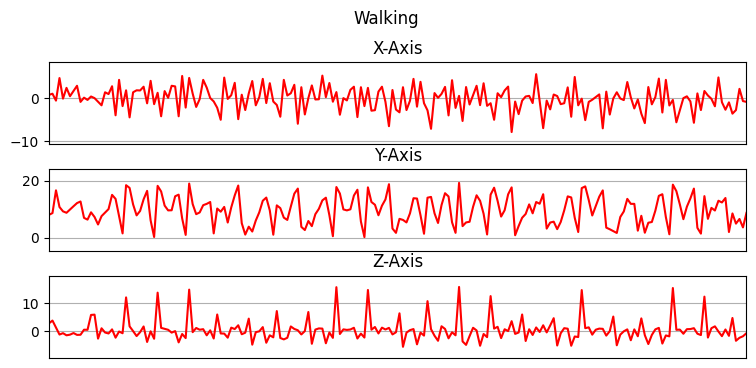

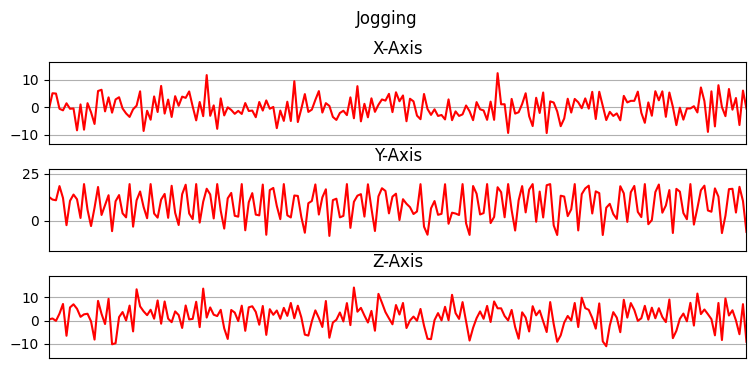

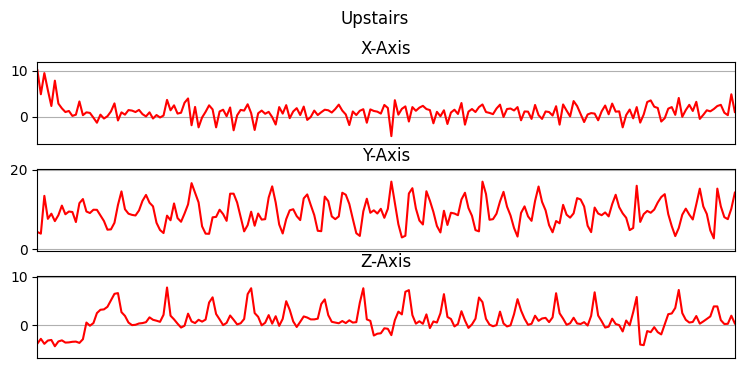

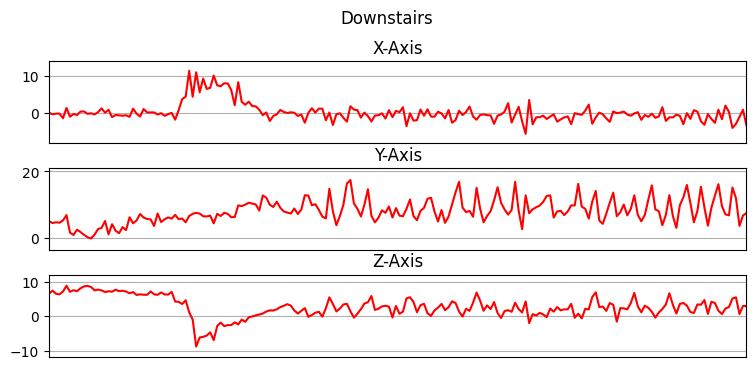

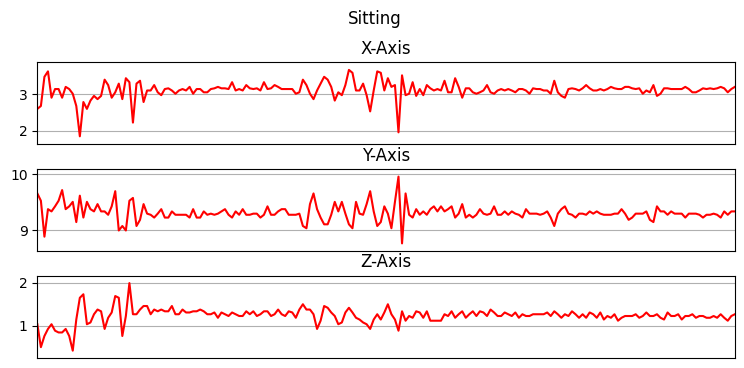

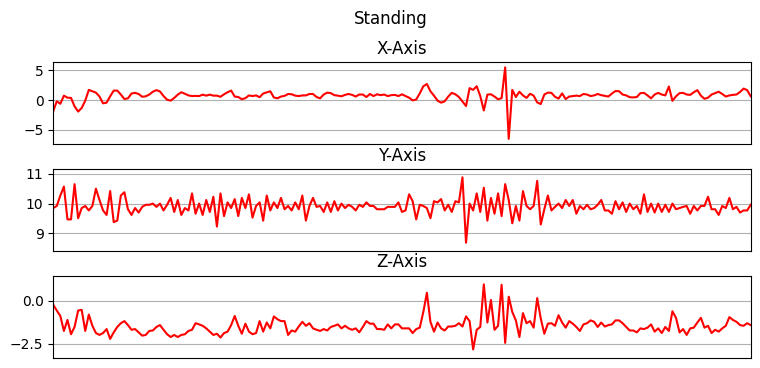

In [14]:
def plot_activity(activity, data):
    fig, (ax0, ax1, ax2) = plt.subplots(nrows=3, figsize=(9, 4), sharex=True)
    plot_axis(ax0, data['time'], data['x'], 'X-Axis')
    plot_axis(ax1, data['time'], data['y'], 'Y-Axis')
    plot_axis(ax2, data['time'], data['z'], 'Z-Axis')
    plt.subplots_adjust(hspace=0.3)
    fig.suptitle(activity)
    plt.subplots_adjust(top=0.85)
    plt.show()

def plot_axis(ax, x, y, title):
    ax.plot(x, y, 'r')
    ax.set_title(title)
    ax.xaxis.set_visible(False)
    ax.set_ylim([min(y) - np.std(y), max(y) + np.std(y)])
    ax.set_xlim([min(x), max(x)])
    ax.grid(True)

for activity in activities:
    data_for_plot = data[(data['activity'] == activity)][:Fs*10]
    plot_activity(activity, data_for_plot)

In [15]:
df = data.drop(['user', 'time'], axis = 1).copy()
df.head()

,activity,x,y,z
0,Jogging,-0.694638,12.680544,0.503953
1,Jogging,5.012288,11.264028,0.953424
2,Jogging,4.903325,10.882658,-0.081722
3,Jogging,-0.612916,18.496431,3.023717
4,Jogging,-1.184970,12.108489,7.205164


In [16]:
df['activity'].value_counts()

activity
Walking       137375
Jogging       129392
Upstairs       35137
Downstairs     33358
Sitting         4599
Standing        3555
Name: count, dtype: int64

In [17]:
Walking = df[df['activity']=='Walking'].head(3555).copy()
Jogging = df[df['activity']=='Jogging'].head(3555).copy()
Upstairs = df[df['activity']=='Upstairs'].head(3555).copy()
Downstairs = df[df['activity']=='Downstairs'].head(3555).copy()
Sitting = df[df['activity']=='Sitting'].head(3555).copy()
Standing = df[df['activity']=='Standing'].copy()

balanced_data = pd.DataFrame()
balanced_data = pd.concat([Walking, Jogging, Upstairs, Downstairs, Sitting, Standing], ignore_index=True)
balanced_data.shape

(21330, 4)

In [18]:
balanced_data['activity'].value_counts()

activity
Walking       3555
Jogging       3555
Upstairs      3555
Downstairs    3555
Sitting       3555
Standing      3555
Name: count, dtype: int64

In [19]:
balanced_data.head()

,activity,x,y,z
0,Walking,0.844462,8.008764,2.792171
1,Walking,1.116869,8.621680,3.786457
2,Walking,-0.503953,16.657684,1.307553
3,Walking,4.794363,10.760075,-1.184970
4,Walking,-0.040861,9.234595,-0.694638


In [20]:
label = LabelEncoder()
balanced_data['label'] = label.fit_transform(balanced_data['activity'])
balanced_data.head()

,activity,x,y,z,label
0,Walking,0.844462,8.008764,2.792171,5
1,Walking,1.116869,8.621680,3.786457,5
2,Walking,-0.503953,16.657684,1.307553,5
3,Walking,4.794363,10.760075,-1.184970,5
4,Walking,-0.040861,9.234595,-0.694638,5


In [21]:
label.classes_

array(['Downstairs', 'Jogging', 'Sitting', 'Standing', 'Upstairs',
       'Walking'], dtype=object)

In [22]:
X = balanced_data[['x', 'y', 'z']]
y = balanced_data['label']

scaler = StandardScaler()
X = scaler.fit_transform(X)

scaled_X = pd.DataFrame(data = X, columns = ['x', 'y', 'z'])
scaled_X['label'] = y.values

scaled_X.head()

,x,y,z,label
0,0.000503,-0.099190,0.337933,5
1,0.073590,0.020386,0.633446,5
2,-0.361275,1.588160,-0.103312,5
3,1.060258,0.437573,-0.844119,5
4,-0.237028,0.139962,-0.698386,5


In [23]:
Fs = 20
frame_size = Fs*4 # 80
hop_size = Fs*2 # 40

def get_frames(df, frame_size, hop_size):

    N_FEATURES = 3

    frames = []
    labels = []
    for i in range(0, len(df) - frame_size, hop_size):
        x = df['x'].values[i: i + frame_size]
        y = df['y'].values[i: i + frame_size]
        z = df['z'].values[i: i + frame_size]

        # Retrieve the used label
        #label = stats.mode(df['label'][i: i + frame_size])[0][0]
        label = df['label'].iloc[i]
        frames.append([x, y, z])
        labels.append(label)

    # Reshape
    frames = np.asarray(frames).reshape(-1, frame_size, N_FEATURES)
    labels = np.asarray(labels)

    return frames, labels

X, y = get_frames(scaled_X, frame_size, hop_size)

X.shape, y.shape

((532, 80, 3), (532,))

In [24]:
from scipy import stats

def get_frames(df, frame_size, hop_size):
    frames = []
    labels = []

    # Ensure DataFrame has numeric index
    df = df.reset_index(drop=True)

    for i in range(0, len(df) - frame_size, hop_size):
        x = df['x'][i: i + frame_size].to_numpy()
        y = df['y'][i: i + frame_size].to_numpy()
        z = df['z'][i: i + frame_size].to_numpy()

        # Retrieve the used label
        #label = stats.mode(df['label'][i: i + frame_size])[0][0]
        label = df['label'].iloc[i]
        frames.append([x, y, z])
        labels.append(label)

    return frames, labels

X, y = get_frames(scaled_X, frame_size, hop_size)

#X.shape, y.shape
X=np.array(X)
y=np.array(y)
X.shape, y.shape

((532, 3, 80), (532,))

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0, stratify = y)
X_train.shape, X_test.shape

((425, 3, 80), (107, 3, 80))

In [26]:
X_train[0].shape, X_test[0].shape

((3, 80), (3, 80))

In [27]:
X_train = X_train.reshape(425, 80, 3, 1)
X_test = X_test.reshape(107, 80, 3, 1)
X_train[0].shape, X_test[0].shape

((80, 3, 1), (80, 3, 1))

In [28]:
model = Sequential()
model.add(Conv2D(32, (2, 2), activation = 'relu', input_shape = X_train[0].shape))
model.add(Dropout(0.1))

model.add(Conv2D(64, (2, 2), activation='relu'))
model.add(Dropout(0.2))

model.add(Flatten())

model.add(Dense(128, activation = 'relu'))
model.add(Dropout(0.5))

model.add(Dense(6, activation='softmax'))

In [29]:
model.compile(optimizer=Adam(learning_rate = 0.003), loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
history = model.fit(X_train, y_train, epochs = 250, validation_data= (X_test, y_test), verbose=1)

Epoch 1/250
14/14 [==============================] - 6s 41ms/step - loss: 1.3571 - accuracy: 0.4376 - val_loss: 0.6653 - val_accuracy: 0.7664
Epoch 2/250
14/14 [==============================] - 0s 6ms/step - loss: 0.5715 - accuracy: 0.7765 - val_loss: 0.5275 - val_accuracy: 0.7570
Epoch 3/250
14/14 [==============================] - 0s 7ms/step - loss: 0.3967 - accuracy: 0.8494 - val_loss: 0.3806 - val_accuracy: 0.8972
Epoch 4/250
14/14 [==============================] - 0s 6ms/step - loss: 0.2589 - accuracy: 0.9200 - val_loss: 0.3732 - val_accuracy: 0.9065
Epoch 5/250
14/14 [==============================] - 0s 8ms/step - loss: 0.1385 - accuracy: 0.9553 - val_loss: 0.3151 - val_accuracy: 0.8972
Epoch 6/250
14/14 [==============================] - 0s 8ms/step - loss: 0.1122 - accuracy: 0.9600 - val_loss: 0.3775 - val_accuracy: 0.8972
Epoch 7/250
14/14 [==============================] - 0s 6ms/step - loss: 0.0824 - accuracy: 0.9694 - val_loss: 0.3616 - val_accuracy: 0.9159
Epoch 8/250


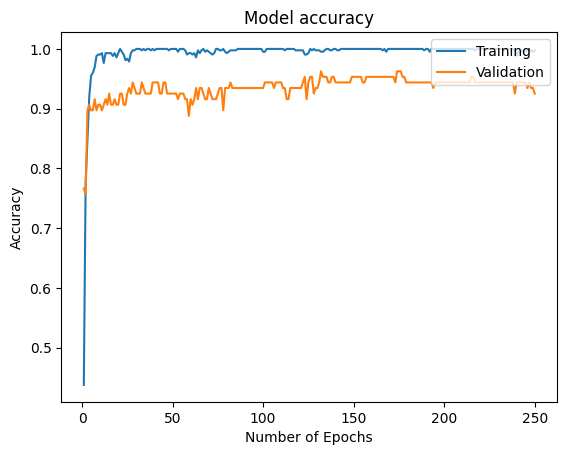

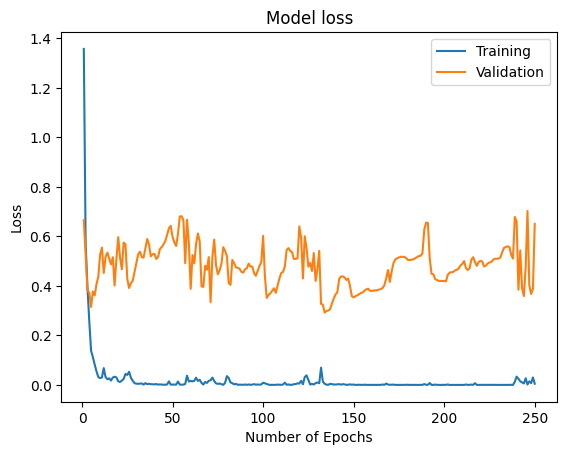

In [30]:
def plot_learningCurve(history, epochs):
  # Plotting the accuracy graph of training & validation
  epoch_range = range(1, epochs+1)
  plt.plot(epoch_range, history.history['accuracy'])
  plt.plot(epoch_range, history.history['val_accuracy'])
  plt.title('Model accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Number of Epochs')
  plt.legend(['Training', 'Validation'], loc='upper right')
  plt.show()

  # Plotting the loss graph of training & validation
  plt.plot(epoch_range, history.history['loss'])
  plt.plot(epoch_range, history.history['val_loss'])
  plt.title('Model loss')
  plt.ylabel('Loss')
  plt.xlabel('Number of Epochs')
  plt.legend(['Training', 'Validation'], loc='upper right')
  plt.show()

plot_learningCurve(history, 250)

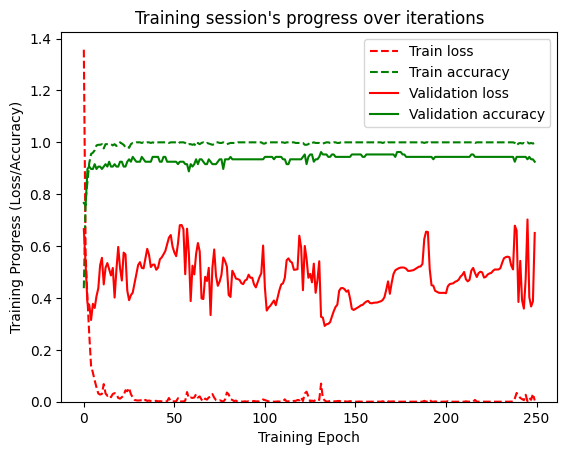

In [31]:
plt.plot(np.array(history.history['loss']), "r--", label = "Train loss")
plt.plot(np.array(history.history['accuracy']), "g--", label = "Train accuracy")
plt.plot(np.array(history.history['val_loss']), "r-", label = "Validation loss")
plt.plot(np.array(history.history['val_accuracy']), "g-", label = "Validation accuracy")
plt.title("Training session's progress over iterations")
plt.legend(loc='upper right')
plt.ylabel('Training Progress (Loss/Accuracy)')
plt.xlabel('Training Epoch')
plt.ylim(0)
plt.show()

In [32]:
def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):
    df_cm = pd.DataFrame(confusion_matrix, index=class_names, columns=class_names)
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must not be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('Truth')
    plt.xlabel('Prediction')

truth = ["Downstairs", "Jogging", "Sitting", "Standing", "Upstairs", "Walking"]
prediction = ["Downstairs", "Jogging", "Sitting", "Standing", "Upstairs", "Walking"]

4/4 [==============================] - 0s 4ms/step


(<Figure size 500x500 with 1 Axes>,
 <Axes: xlabel='predicted label', ylabel='true label'>)

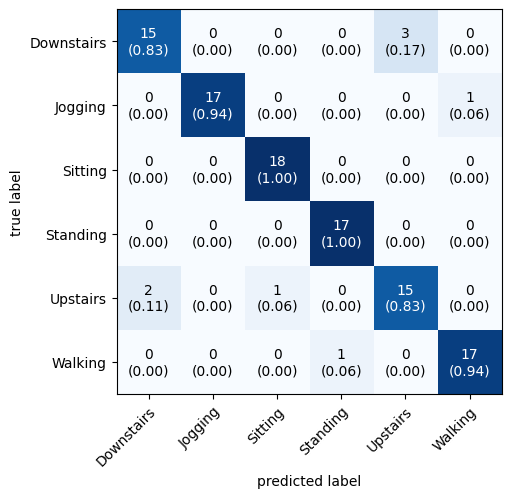

In [33]:
y_pred = np.argmax(model.predict(X_test), axis=-1)
mat = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(conf_mat=mat, class_names=label.classes_, show_normed=True, figsize=(5,5))

In [34]:
from sklearn.metrics import precision_score, recall_score, accuracy_score, hamming_loss, f1_score
print("Precision Score : ",precision_score(y_test, y_pred, average=None))
print("Recall Score : ",recall_score(y_test, y_pred, average=None))
print("F1 Score : ",f1_score(y_test, y_pred, average=None))
print("Accuracy Score :", accuracy_score(y_test, y_pred, normalize=True))
print("Loss Score :", hamming_loss(y_test, y_pred))

Precision Score :  [0.88235294 1.         0.94736842 0.94444444 0.83333333 0.94444444]
Recall Score :  [0.83333333 0.94444444 1.         1.         0.83333333 0.94444444]
F1 Score :  [0.85714286 0.97142857 0.97297297 0.97142857 0.83333333 0.94444444]
Accuracy Score : 0.9252336448598131
Loss Score : 0.07476635514018691
